./traj/backcycle2.txt
elapsed
407
encpos1
407
encpos2
407


interactive(children=(IntSlider(value=0, description='start_index', max=406), IntSlider(value=406, description…

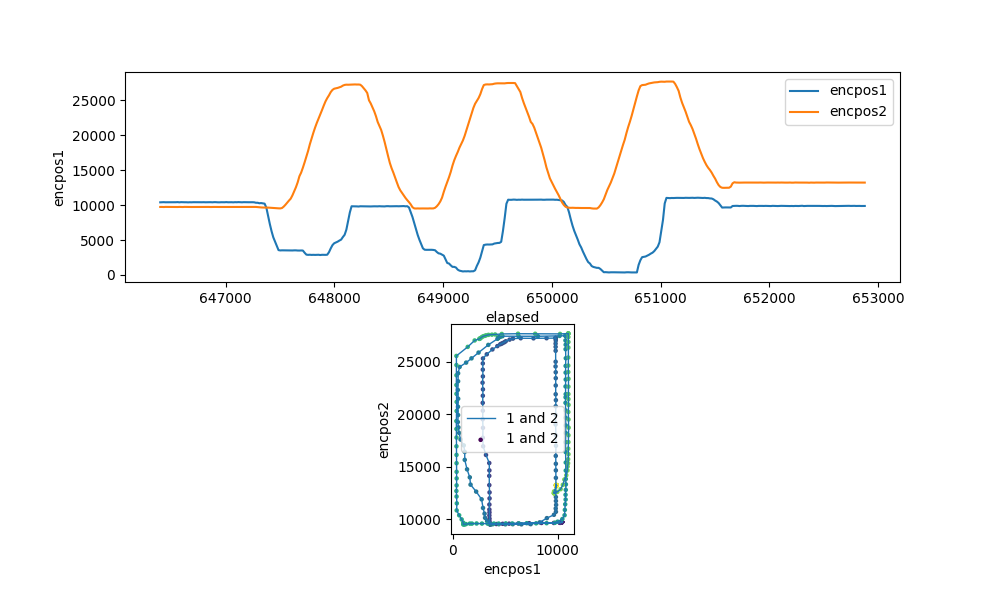

In [23]:
import pandas as pd
import numpy as np
from scipy.stats import trim_mean
import glob
import os
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider
%matplotlib widget

list_of_files = [f for f in glob.glob('./traj/*') if not os.path.isdir(f)] #take all files but not folders
latest_file = max(list_of_files, key=os.path.getctime)

file_path = latest_file
# file_path = "./traj/jerkybrainside.txt"
print(latest_file)

# Read the text file into a list of lines
with open(file_path, 'r') as file:
    lines = file.readlines()

labels = [
    'elapsed', 
    'encpos1', 'encpos2'
]
data_dict = {label: [] for label in labels}

last_delimiter_index = 0

messages = []
for i in range(len(lines)):
    if(lines[i].startswith('\n')):
        messages.append(lines[last_delimiter_index:i])
        last_delimiter_index = i
        # print("found ", i)

for message in messages:
    # print("message")
    # message_dict = dict.fromkeys(labels, [])
    message_dict = {label: [] for label in labels}
    for label in labels:
        for line in message:
                if(line.startswith(label)):
                    # print("append ", label, float(line.split(':')[1]))
                    message_dict[label].append(float(line.split(':')[1]))
                    # print(message_dict[label])
    # print(message_dict)
    full = True
    for key in message_dict:
        if(len(message_dict[key]) == 0):
            full=False
            break
    if(full):
        for label in labels:
            # print((message_dict[label]))
            data_dict[label].append(message_dict[label][0])

for series in data_dict:
    print(series)
    print(len(data_dict[series]))

# Create a dataframe from the extracted values
df_raw = pd.DataFrame(data_dict)
df = None #cropped version

plt.close('all')
fig, axs = plt.subplots(2, 1, figsize=(10,6))
@interact(start_index=IntSlider(min=0, max=len(df_raw)-1, step=1, value=0),
          end_index=IntSlider(min=0, max=len(df_raw)-1, step=1, value=len(df_raw)-1))
def display_image(start_index, end_index):
    if(start_index >= end_index):
        return

    global df
    df = df_raw[start_index:end_index]
    
    axs[0].clear()
    axs[0].set_xlabel('elapsed')
    axs[0].set_ylabel('encpos1')
    axs[0].plot(df['elapsed'], df['encpos1'], label='encpos1')
    axs[0].plot(df['elapsed'], df['encpos2'], label='encpos2')
    axs[0].legend()

    axs[1].clear()
    axs[1].set_xlabel('encpos1')
    axs[1].set_ylabel('encpos2')
    axs[1].plot(df['encpos1'], df['encpos2'], linewidth=1, label=f'1 and 2')
    axs[1].scatter(df['encpos1'], df['encpos2'], c=df['elapsed'], s=5, label=f'1 and 2')
    axs[1].legend()
    axs[1].set_aspect('equal', adjustable='box')
plt.show()

In [27]:
encpos1_zero = -5608 #encoder cont_angle when latched 3/27/24
encpos2_zero = 28480

traj_df = df.copy().reset_index(drop=True) #index from 0, dont put the old index as a new column
traj_df['elapsed'] = traj_df['elapsed']-traj_df['elapsed'][0]

traj_df['encpos1_zero'] = encpos1_zero
traj_df['encpos2_zero'] = encpos2_zero

traj_df.to_csv(f"{file_path[:-4]}.csv", index=False) #write to csv with same name, don't have index as column 
traj_df

,elapsed,encpos1,encpos2,encpos1_zero,encpos2_zero
0,0.0,8980.0,10102.0,-5608,28480
1,16.0,8296.0,9698.0,-5608,28480
2,32.0,7440.0,9528.0,-5608,28480
3,48.0,6556.0,9510.0,-5608,28480
4,64.0,5728.0,9524.0,-5608,28480
...,...,...,...,...,...
87,1392.0,10668.0,10380.0,-5608,28480
88,1408.0,10456.0,10016.0,-5608,28480
89,1424.0,10008.0,9766.0,-5608,28480
90,1440.0,9748.0,9660.0,-5608,28480


1456.0


,elapsed,encpos1,encpos2,phase
0,0.0,8980.000000,10102.000000,0.000000
1,10.0,8547.802198,9846.725275,0.006868
2,20.0,8070.241758,9653.164835,0.013736
3,30.0,7529.362637,9545.747253,0.020604
4,40.0,6973.714286,9518.505495,0.027473
...,...,...,...,...
95,950.0,10779.230769,27450.241758,0.652473
96,960.0,10761.538462,27179.802198,0.659341
97,970.0,10757.824176,26915.186813,0.666209
98,980.0,10770.461538,26657.384615,0.673077


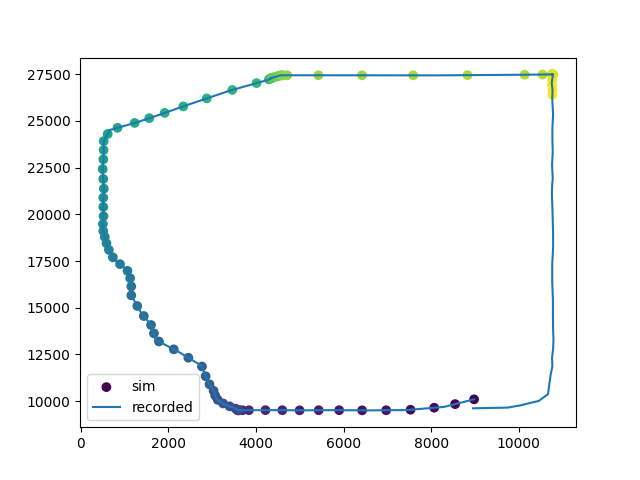

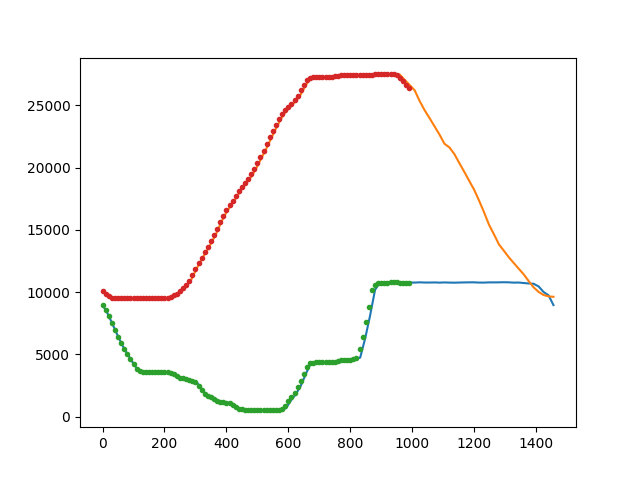

In [26]:
#simulate traj follow
elapseds = np.arange(0, 1000, 10)
speed = 1
period = traj_df['elapsed'][len(traj_df)-1]/speed
# period = 150

print(period)
follow_df = pd.DataFrame({'elapsed': [], 'encpos1': [], 'encpos2': [], 'phase': []})
for elapsed in elapseds:
    phase = elapsed/period
    progress = (phase - int(phase)) * len(traj_df) #goes from 0 to length of traj
    index = int(progress)
    index_frac = progress - index

    if(index + 1 < len(traj_df)):
        index_next = index + 1
    else:
        index_next = 0
    
    follow_df.loc[len(follow_df)] = [
        elapsed, 
        (1-index_frac)*traj_df['encpos1'][index] + (index_frac)*traj_df['encpos1'][index_next], 
        (1-index_frac)*traj_df['encpos2'][index] + (index_frac)*traj_df['encpos2'][index_next], 
        phase
    ]

plt.figure()
plt.scatter(follow_df['encpos1'], follow_df['encpos2'], c=follow_df['elapsed'],  label=f'sim')
plt.plot(traj_df['encpos1'], traj_df['encpos2'], '-', label=f'recorded')
plt.legend()

plt.figure()
plt.plot(traj_df['elapsed'], traj_df['encpos1'], '-')
plt.plot(traj_df['elapsed'], traj_df['encpos2'], '-')
plt.plot(follow_df['elapsed'], follow_df['encpos1'], '.')
plt.plot(follow_df['elapsed'], follow_df['encpos2'], '.')

follow_df

In [145]:
plt.close('all')